# Arginine-glutamic acid dipeptide repeats (RERE)

The Arginine-glutamic acid dipeptide repeats (RERE) RERE gene encodes a nuclear receptor coregulator that positively regulates retinoic acid signaling [Fregeau et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27087320/). A high percentage of RERE pathogenic variants affect a 21 amino acid (amino acids 1425–1445), histidine-rich region of the Atrophin-1 domain [Jordan et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29330883/). The authors noted that Of the 19 individuals with NEDBEH described here and by Fregeau et al. (2016), nine (47%) carry sequence variants that affect a histidine-rich region of the Atrophin-1 domain that spans 21 amino acids (1425– 1445). The amino acid sequence in this region is 100% conserved down to Xenopus and zebrafish, but the functional significance of this domain is currently unknown.

Let us try to reproduce Table 3 of https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903952/
To do this, we will want to use (for instance)  Abnormal brain morphology HP:0012443 for "Brain anomalies", and use the MTC feature that tests only one term at a time (this will mean no Bonferroni is applied, just as in the original publication).  

Take a look at "analysis_config.specify_terms_strategy()"
Do this once for each of the items in Table 3 with the appropriate HPO term.
Presumably, we will also not achieve statistical significance, but if we get a comparable result as the authors, this will be fine.

As a stretch goal, we can figure out how to do "Number of defects per individual"


In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.5.1.dev0


### RERE
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for RERE.

In [2]:
gene_symbol = 'RERE'
mane_tx_id = 'NM_012102.4'
mane_protein_id = 'NP_036234.3' # FYVE, RhoGEF and PH domain-containing protein 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.20") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 19 phenopackets
Individuals Processed: 100%|██████████| 19/19 [00:02<00:00,  8.27individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,17
Intellectual disability,HP:0001249,17
Autistic behavior,HP:0000729,12
Hypotonia,HP:0001252,8
Thin corpus callosum,HP:0033725,7
Reduced cerebral white matter volume,HP:0034295,6
Ventricular septal defect,HP:0001629,5
Short stature,HP:0004322,5
Strabismus,HP:0000486,4
Ventriculomegaly,HP:0002119,4


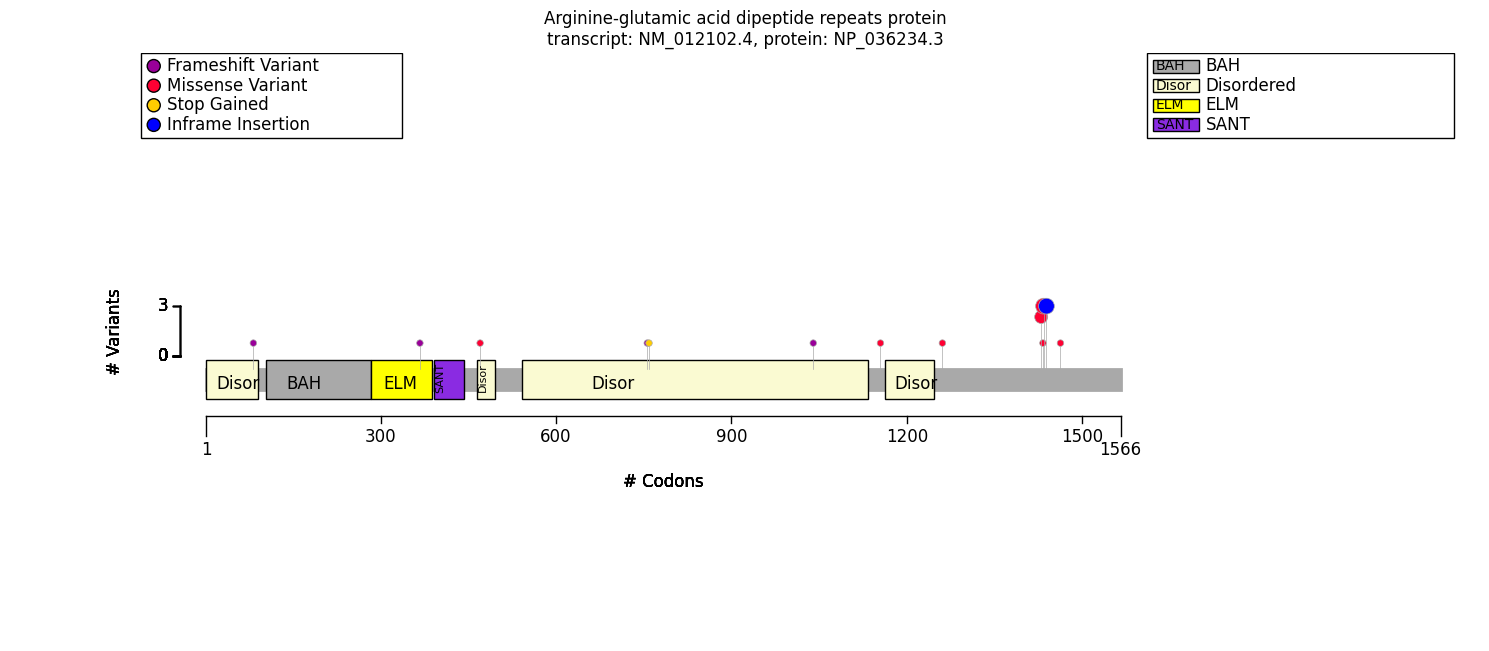

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 90,1,p.Ser84ValfsTer4
BAH,DOMAIN,103 - 283,0,
ELM2,DOMAIN,284 - 387,1,p.Leu369CysfsTer16
SANT,DOMAIN,391 - 443,0,
Disordered,REGION,464 - 495,1,p.Val471Ile
Disordered,REGION,542 - 1133,3,p.Pro1041LeufsTer40; p.Thr758SerfsTer36; p.Gln760Ter
Disordered,REGION,1162 - 1246,0,


In [8]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [9]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant
from gpsea.model import VariantEffect


is_frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(
    variant_predicate=is_frameshift,
)

gt_predicate.display_question()

'What is the genotype group: No allele, Monoallelic'

In [10]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,31
HMF02,Skipping term because no genotype has more than one observed HPO count,17
HMF03,Skipping term because of a child term with the same individual counts,2
HMF05,Skipping term because one genotype had zero observations,6
HMF06,Skipping term with less than 7 observations (not powered for 2x2),13
HMF08,Skipping general term,65
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.25,125


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         No allele          \
                                                       Count Percent   
Thin corpus callosum [HP:0033725]                        7/7    100%   
Broad eyebrow [HP:0011229]                              0/15      0%   
Reduced cerebral white matter volume [HP:0034295]        6/6    100%   
Macrocephaly [HP:0000256]                               0/14      0%   
Poor suck [HP:0002033]                                   0/7      0%   
Downslanted palpebral fissures [HP:0000494]             1/15      7%   
Hypertelorism [HP:0000316]                              2/15     13%   
Short stature [HP:0004322]                               5/8     62%   
Global developmental delay [HP:0001263]                14/14    100%   
Intellectual disability [HP:0001249]                   14/14    100%   
Ventriculomegaly [HP:0002119]                            4/7     57%   
Cerebellar vermis hypoplasia [HP:0001320]                3/7     43%   
Intrauterine growth retardation [HP:0001511]             3/8     38%   
Sensorineural hearing impairment [HP:0000407]           4/14     29%   
Scoliosis [HP:0002650]                                  2/15     13%   
Coloboma [HP:0000589]                                   4/15     27%   
Triangular face [HP:0000325]                            2/15     13%   
Epicanthus [HP:0000286]                                 2/15     13%   
Hypotonia [HP:0001252]                                  7/15     47%   
Abnormal axial skeleton morphology [HP:0009121]          6/6    100%   
Abnormal ocular adnexa morphology [HP:0030669]           5/5    100%   
Morphological central nervous system abnormalit...       9/9    100%   
Autistic behavior [HP:0000729]                           9/9    100%   
Atypical behavior [HP:0000708]                         10/10    100%   
Neurodevelopmental delay [HP:0012758]                  14/14    100%   
Neurodevelopmental abnormality [HP:0012759]            14/14    100%   
Ventricular septal defect [HP:0001629]                   4/8     50%   
Abnormal cardiac septum morphology [HP:0001671]          6/6    100%   
Deeply set eye [HP:0000490]                             3/15     20%   
Vesicoureteral reflux [HP:0000076]                      3/15     20%   
Choanal atresia [HP:0000453]                            3/15     20%   
Hypospadias [HP:0000047]                                 2/6     33%   
Abnormal muscle tone [HP:0003808]                        8/8    100%   
Patent foramen ovale [HP:0001655]                        2/8     25%   
Abnormal pinna morphology [HP:0000377]                   6/6    100%   
Clinodactyly of the 5th finger [HP:0004209]              2/8     25%   
Abnormal digit morphology [HP:0011297]                   6/6    100%   
Abnormal appendicular skeleton morphology [HP:0...       6/6    100%   
Single transverse palmar crease [HP:0000954]             2/7     29%   
Broad thumb [HP:0011304]                                 2/8     25%   
Microphthalmia [HP:0000568]                              2/7     29%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Thin corpus callosum [HP:0033725]                          0/2      0%   
Broad eyebrow [HP:0011229]                                 2/4     50%   
Reduced cerebral white matter volume [HP:0034295]          0/2      0%   
Macrocephaly [HP:0000256]                                  2/4     50%   
Poor suck [HP:0002033]                                     2/3     67%   
Downslanted palpebral fissures [HP:0000494]                2/4     50%   
Hypertelorism [HP:0000316]                                 2/4     50%   
Short stature [HP:0004322]                                 0/3      0%   
Global developmental delay [HP:0001263]                    3/4     75%   
Intellectual disability [HP:0001249]                       3/4     75%   
Ventriculomegal

In [12]:
is_frameshift = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(
    variant_predicate=is_frameshift,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         No allele          \
                                                       Count Percent   
Thin corpus callosum [HP:0033725]                        1/3     33%   
Choanal atresia [HP:0000453]                             3/9     33%   
Reduced cerebral white matter volume [HP:0034295]        1/3     33%   
Cerebellar vermis hypoplasia [HP:0001320]                0/5      0%   
Hypotonia [HP:0001252]                                   2/9     22%   
Macrocephaly [HP:0000256]                                2/8     25%   
Deeply set eye [HP:0000490]                              0/9      0%   
Vesicoureteral reflux [HP:0000076]                       0/9      0%   
Broad eyebrow [HP:0011229]                               2/9     22%   
Coloboma [HP:0000589]                                    3/9     33%   
Hypertelorism [HP:0000316]                               3/9     33%   
Global developmental delay [HP:0001263]                  7/8     88%   
Intellectual disability [HP:0001249]                     7/8     88%   
Poor suck [HP:0002033]                                   2/5     40%   
Single transverse palmar crease [HP:0000954]             0/5      0%   
Microphthalmia [HP:0000568]                              0/5      0%   
Low-set ears [HP:0000369]                                2/6     33%   
High palate [HP:0000218]                                 0/9      0%   
Preauricular pit [HP:0004467]                            0/9      0%   
Clinodactyly of the 5th finger [HP:0004209]              2/5     40%   
Scoliosis [HP:0002650]                                   2/9     22%   
Triangular face [HP:0000325]                             2/9     22%   
Downslanted palpebral fissures [HP:0000494]              2/9     22%   
Sensorineural hearing impairment [HP:0000407]            1/8     12%   
Abnormal axial skeleton morphology [HP:0009121]          5/5    100%   
Abnormal ocular adnexa morphology [HP:0030669]           4/4    100%   
Morphological central nervous system abnormalit...       3/3    100%   
Autistic behavior [HP:0000729]                           5/5    100%   
Atypical behavior [HP:0000708]                           5/5    100%   
Neurodevelopmental delay [HP:0012758]                    7/7    100%   
Neurodevelopmental abnormality [HP:0012759]              7/7    100%   
Ventricular septal defect [HP:0001629]                   3/6     50%   
Abnormal cardiac septum morphology [HP:0001671]          3/3    100%   
Abnormal cerebral white matter morphology [HP:0...       1/1    100%   
Abnormal cerebral morphology [HP:0002060]                2/2    100%   
Abnormal brain morphology [HP:0012443]                   2/2    100%   
Ventriculomegaly [HP:0002119]                            2/4     50%   
Abnormal corpus callosum morphology [HP:0001273]         1/1    100%   
Abnormal muscle tone [HP:0003808]                        3/3    100%   
Abnormal pinna morphology [HP:0000377]                   5/5    100%   
Abnormal digit morphology [HP:0011297]                   3/3    100%   
Abnormal appendicular skeleton morphology [HP:0...       3/3    100%   
Epicanthus [HP:0000286]                                  1/9     11%   
Broad thumb [HP:0011304]                                 1/5     20%   
Short stature [HP:0004322]                               2/5     40%   
Intrauterine growth retardation [HP:0001511]             2/6     33%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Thin corpus callosum [HP:0033725]                          6/6    100%   
Choanal atresia [HP:0000453]                              0/10      0%   
Reduced cerebral white matter volume [HP:0034295]          5/5    100%   
Cerebellar vermis hypoplasia [HP:0001320]                  3/5     60%   
Hypotonia [HP:0001252]                                    6/10     60%   
Macrocephaly [HP:0000256]

In [13]:
from gpsea.model.genome import Region
is_region = VariantPredicates.region(Region(542, 1133), tx_id=mane_tx_id)

gt_predicate = autosomal_dominant(
    variant_predicate=is_region,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                         No allele          \
                                                       Count Percent   
Macrocephaly [HP:0000256]                               0/16      0%   
Broad eyebrow [HP:0011229]                              0/16      0%   
Thin corpus callosum [HP:0033725]                        7/8     88%   
Reduced cerebral white matter volume [HP:0034295]        6/7     86%   
Scoliosis [HP:0002650]                                  2/16     12%   
Triangular face [HP:0000325]                            2/16     12%   
Short stature [HP:0004322]                               5/9     56%   
Cerebellar vermis hypoplasia [HP:0001320]                3/7     43%   
Clinodactyly of the 5th finger [HP:0004209]              3/8     38%   
Intrauterine growth retardation [HP:0001511]             3/8     38%   
Hypertelorism [HP:0000316]                              3/16     19%   
Abnormal axial skeleton morphology [HP:0009121]          7/7    100%   
Abnormal ocular adnexa morphology [HP:0030669]           7/7    100%   
Morphological central nervous system abnormalit...       9/9    100%   
Autistic behavior [HP:0000729]                           9/9    100%   
Atypical behavior [HP:0000708]                         10/10    100%   
Global developmental delay [HP:0001263]                14/15     93%   
Neurodevelopmental delay [HP:0012758]                  14/14    100%   
Neurodevelopmental abnormality [HP:0012759]            14/14    100%   
Intellectual disability [HP:0001249]                   14/15     93%   
Ventricular septal defect [HP:0001629]                   4/8     50%   
Abnormal cardiac septum morphology [HP:0001671]          6/6    100%   
Ventriculomegaly [HP:0002119]                            4/8     50%   
Hypospadias [HP:0000047]                                 2/7     29%   
Coloboma [HP:0000589]                                   4/16     25%   
Hypotonia [HP:0001252]                                  7/16     44%   
Abnormal muscle tone [HP:0003808]                        9/9    100%   
Patent foramen ovale [HP:0001655]                        2/8     25%   
Abnormal pinna morphology [HP:0000377]                   7/7    100%   
Sensorineural hearing impairment [HP:0000407]           4/15     27%   
Abnormal digit morphology [HP:0011297]                   7/7    100%   
Abnormal appendicular skeleton morphology [HP:0...       7/7    100%   
Single transverse palmar crease [HP:0000954]             2/7     29%   
Broad thumb [HP:0011304]                                 2/8     25%   
Attention deficit hyperactivity disorder [HP:00...       2/7     29%   
Microphthalmia [HP:0000568]                              2/7     29%   
Spastic tetraparesis [HP:0001285]                        2/8     25%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Macrocephaly [HP:0000256]                                  2/2    100%   
Broad eyebrow [HP:0011229]                                 2/3     67%   
Thin corpus callosum [HP:0033725]                          0/1      0%   
Reduced cerebral white matter volume [HP:0034295]          0/1      0%   
Scoliosis [HP:0002650]                                     1/3     33%   
Triangular face [HP:0000325]                               1/3     33%   
Short stature [HP:0004322]                                 0/2      0%   
Cerebellar vermis hypoplasia [HP:0001320]                  0/3      0%   
Clinodactyly of the 5th finger [HP:0004209]                0/3      0%   
Intrauterine growth retardation [HP:0001511]               0/3      0%   
Hypertelorism [HP:0000316]                                 1/3     33%   
Abnormal axial skeleton morphology [HP:0009121]            2/2    100%   
Abnormal ocular adnexa morphology [HP:0030669]             2/2    100%   
Morphological central nervous system abnormalit...         1/1    100%   
Autisti